In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas
%matplotlib inline
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(
    color=['#1b9e77','#d95f02','#7570b3','#e7298a'])

# Refresh the latest JHU CSSE data
(see https://github.com/CSSEGISandData/COVID-19)

In [2]:
!git submodule update --remote --merge

# Create DataFrames for the time series data

In [3]:
# Daily number of cases.
confirmed_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
# Daily counts of 
deaths_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
recoveries_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

# Inspect the first few rows of data

In [4]:
recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
0,Anhui,Mainland China,31.8257,117.2264,0,0,0,0,0,0,...,873,917,936,956,970,979,979,984,984,984.0
1,Beijing,Mainland China,40.1824,116.4142,0,0,1,2,2,2,...,276,282,288,297,297,299,303,308,315,320.0
2,Chongqing,Mainland China,30.0572,107.8740,0,0,0,0,0,0,...,450,469,490,502,512,513,526,527,542,547.0
3,Fujian,Mainland China,26.0789,117.9874,0,0,0,0,0,0,...,247,255,260,270,277,284,295,295,295,295.0
4,Gansu,Mainland China,36.0611,103.8343,0,0,0,0,0,0,...,84,85,86,87,87,87,87,87,88,88.0


# Inspect the last few rows of data

In [5]:
regions = list(sorted(set(confirmed_df['Country/Region'].values)))

In [6]:
recoveries_df.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
328,New Mexico,US,34.8405,-106.2485,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
329,North Dakota,US,47.5289,-99.7840,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
330,South Dakota,US,44.2998,-99.4388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
331,West Virginia,US,38.4912,-80.9545,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
332,Wyoming,US,42.7560,-107.3025,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [7]:
# The data currently begins at this date.
tracking_start_date = '1/22/20'
def region_aggregate(df):
    return df.loc[:,tracking_start_date:].sum(axis=0)

def get_nan_mask(df):
    return np.isnan(df.loc[:,tracking_start_date:].values.astype(np.float64)).any(axis=0)

def plot_provinces(province_names, **kwargs):
    """Aggregate over a list of provinces (strings that match the 'Province/State' category) and plot"""
    mask = confirmed_df.isin({'Province/State': province_names}).any(1)
    maskaggr = lambda x: region_aggregate(x[mask])
    nan_mask = get_nan_mask(confirmed_df)
    plot_overview(maskaggr(confirmed_df), maskaggr(recoveries_df), maskaggr(deaths_df), nan_mask=nan_mask, region='/'.join(province_names), **kwargs)

plot_counties = plot_provinces

def plot_province_substring_match(province_names, **kwargs):
    mask = confirmed_df["Province/State"].str.contains("|".join(province_names), na=False)
    maskaggr = lambda x: region_aggregate(x[mask])
    nan_mask = get_nan_mask(confirmed_df)
    plot_overview(maskaggr(confirmed_df), maskaggr(recoveries_df), maskaggr(deaths_df), 
                  nan_mask=nan_mask,
                  region='/'.join(province_names), **kwargs)
    
def plot_states(state_names, **kwargs):
    state_names_with_commas = [', ' + n for n in state_names]
    mask = confirmed_df["Province/State"].str.contains("|".join(state_names_with_commas), na=False)
    maskaggr = lambda x: region_aggregate(x[mask])
    nan_mask = get_nan_mask(confirmed_df)
    plot_overview(maskaggr(confirmed_df), maskaggr(recoveries_df), maskaggr(deaths_df), nan_mask=nan_mask,region='/'.join(state_names), **kwargs)

def plot_regions(region_names, **kwargs):
    """Aggregate over a list of regions (strings that match the 'Country/Region' category) and plot"""
    mask = confirmed_df.isin({'Country/Region': region_names}).any(1)
    maskaggr = lambda x: region_aggregate(x[mask])
    nan_mask = get_nan_mask(confirmed_df)
    plot_overview(maskaggr(confirmed_df), maskaggr(recoveries_df), maskaggr(deaths_df), nan_mask=nan_mask, region='/'.join(region_names), **kwargs)

def plot_overview(confirmed, recoveries, deaths, region='Global', nan_mask=None, fig=None, ax=None):
    """This is the primary plotting command."""
    tick_spacing = 8
    alpha = 0.8
    # Confirmed = active + deaths + recoveries.
    active = pandas.Series(confirmed.values.astype(np.int32) - deaths.values.astype(np.int32) - recoveries.values.astype(np.int32),
                           confirmed.index)
    plt.rcParams.update({'font.size':  18})
    if fig is None:
        fig = plt.figure(figsize=(10,8), facecolor=(1, 1, 1))
        ax = fig.gca()
    ax.bar(confirmed.index, confirmed.values, label="Total Cases", alpha=1.)
    ax.bar(confirmed.index, active, label="Total Active Cases", alpha=alpha)
    ax.bar(recoveries.index, recoveries.values, label="Total Recoveries", alpha=alpha)
    ax.bar(deaths.index, deaths.values, label="Total Deaths", alpha=1.0)
    joint = np.asarray([(deaths, "total deaths"), (confirmed, "total cases"), (recoveries, "total recoveries"),
                     (active, "total active cases")])
    if nan_mask is None:
        ann_idx = -1
    else:
        ann_idx = np.where(np.logical_not(nan_mask))[-1][-1]
    sortinds = np.argsort([deaths.values[ann_idx], 
                           confirmed.values[ann_idx],
                           recoveries.values[ann_idx],
                           active.values[ann_idx]])
    joint = joint[sortinds]

    for idx, (ser, name) in enumerate(joint.tolist()):
        ax.annotate("{:,} {}".format(int(ser.values[ann_idx]), name), 
                    (ser.index[ann_idx], ser.values[ann_idx]), 
                    (.6, .2*(idx + 1)), 
                    textcoords='axes fraction',
                bbox=dict(boxstyle="round", fc="w", alpha=0.8),
                    fontsize=14,
                arrowprops={'arrowstyle': '->'})
    if nan_mask is not None:
        assert(nan_mask.size == confirmed.index.size)
        for (day_idx, isnan) in enumerate(nan_mask):
            if isnan:
                ax.annotate("Missing some data on {}".format(confirmed.index[day_idx]), 
                    (confirmed.index[day_idx], 0), 
                    (0.6, -0.1),
                            textcoords='axes fraction',
                             bbox=dict(boxstyle="round", fc="gray", alpha=0.8),
                    fontsize=14,
                arrowprops={'arrowstyle': '->'})
                    

    ax.set_xlabel("Date")
    ax.set_ylabel("Number of People")
    ax.grid('on', which='both', axis='y')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    region_str = region if len(region) < 30 else region[:30] + '...'
    ax.set_title('Overview of COVID-19 in {} Region\nLast updated: {}'.format(region_str, confirmed.index[-1]))
    ax.legend(loc='upper left')
    

# This custom command should show the same data as the next command

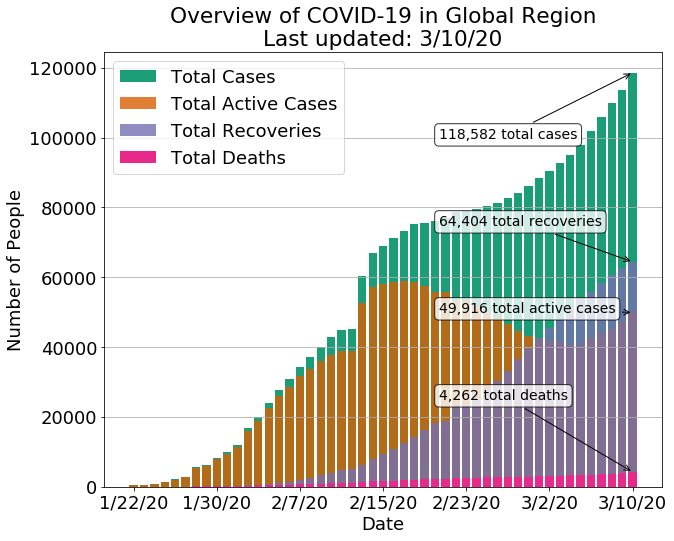

In [8]:
# Daily record of number of current confirmed cases.
global_confirmed = region_aggregate(confirmed_df)
# Daily record of number of cumulative deaths.
global_deaths = region_aggregate(deaths_df)
# Daily record of number of cumulative recoveries.
global_recoveries = region_aggregate(recoveries_df)
plot_overview(global_confirmed, global_recoveries, global_deaths, region='Global')

# This plots for all recorded regions.

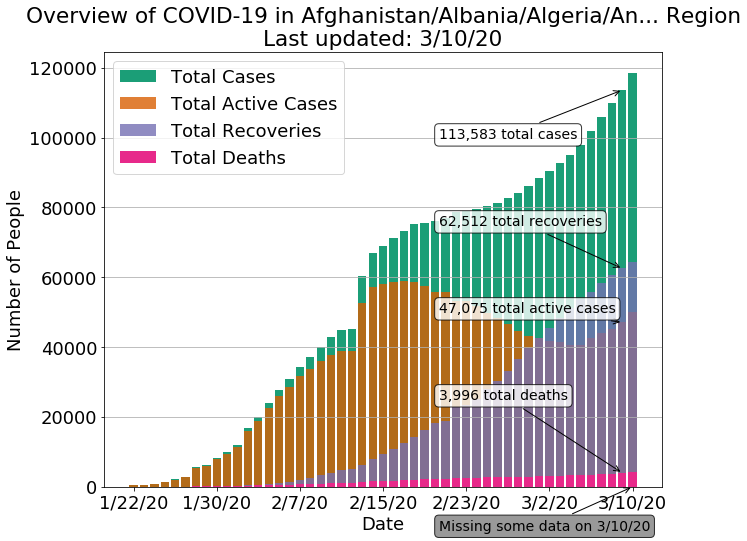

In [9]:
plot_regions(region_names=regions)

# Plot for a single specific region.

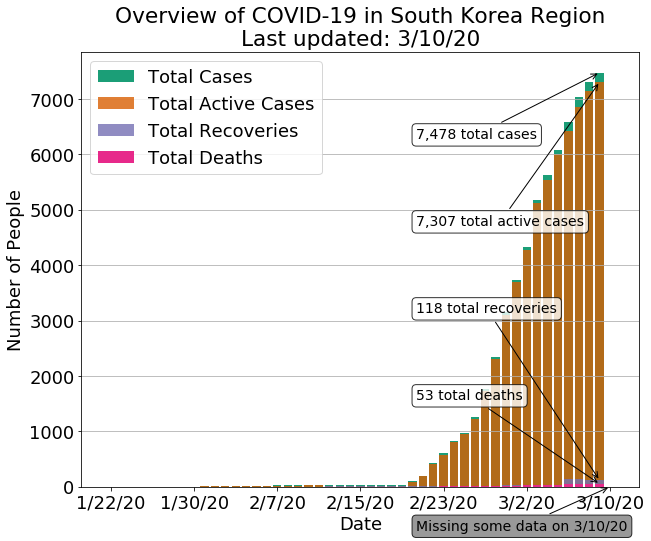

In [10]:
plot_regions(['South Korea'])

# Keep plotting a few more countries with high numbers of confirmed cases.

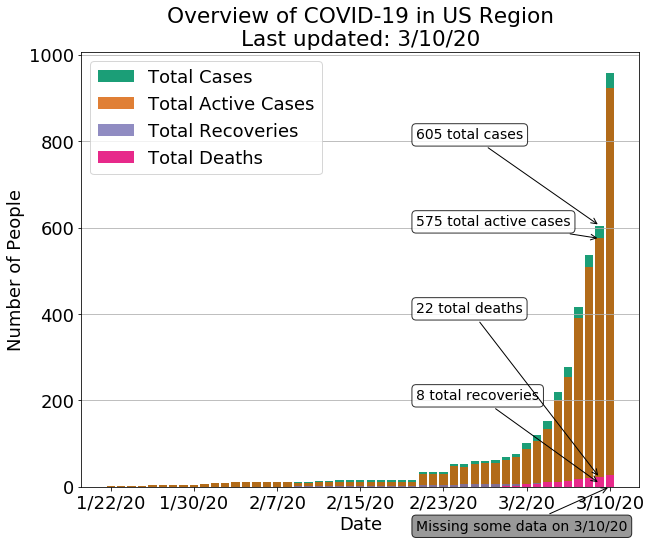

In [11]:
plot_regions(['US'])

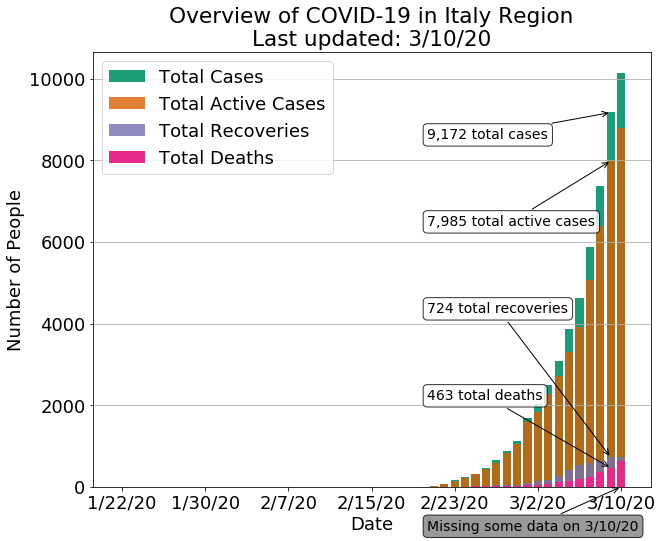

In [12]:
plot_regions(['Italy'])

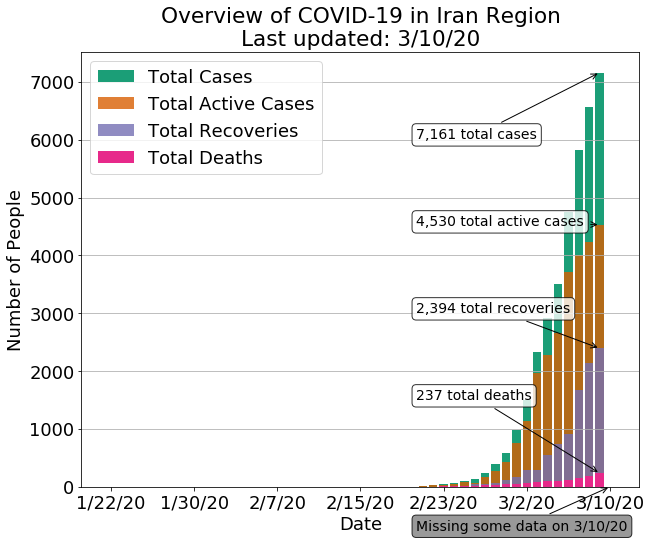

In [13]:
plot_regions(['Iran'])

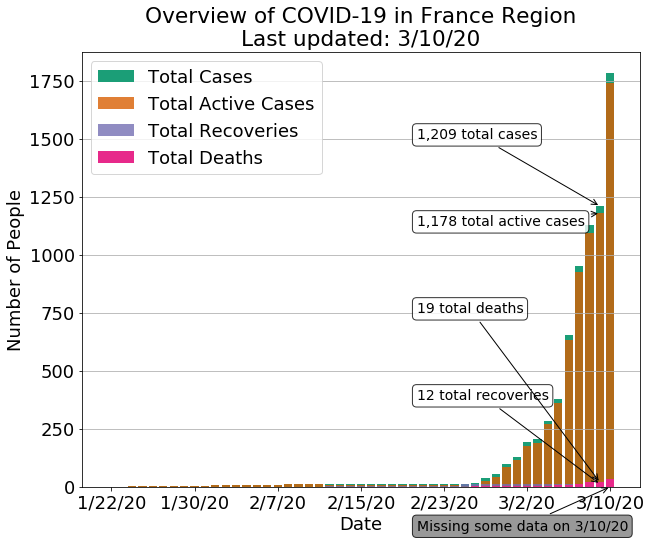

In [14]:
plot_regions(['France'])

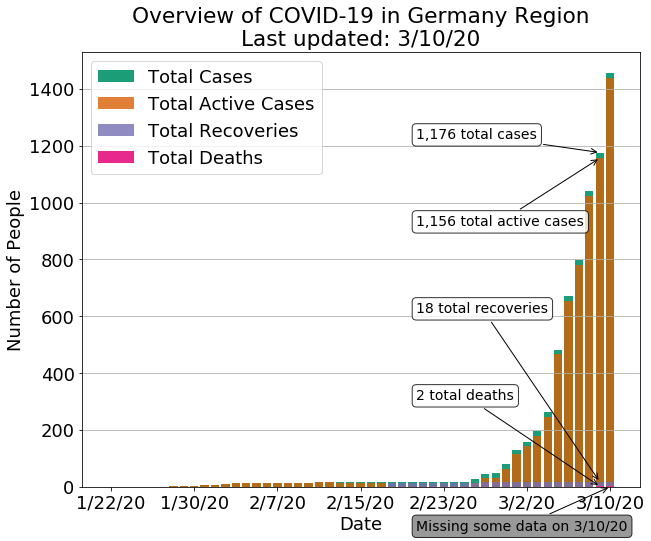

In [15]:
plot_regions(['Germany'])

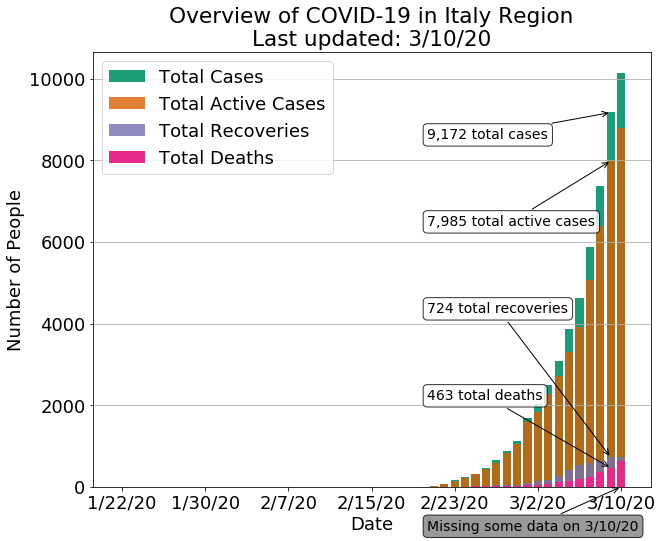

In [16]:
plot_regions(['Italy'])

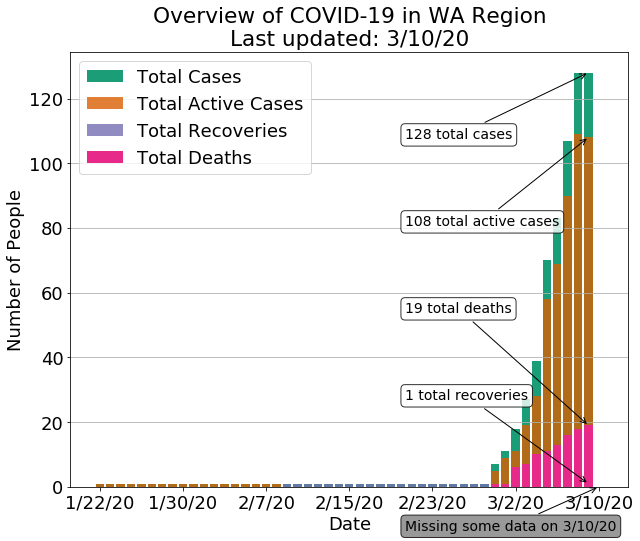

In [17]:
plot_states(['WA'])

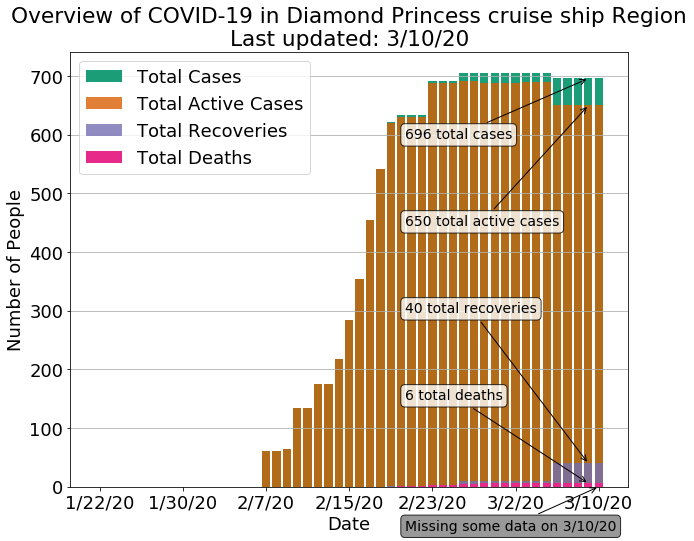

In [18]:
plot_provinces(['Diamond Princess cruise ship'])

# We can also plot from the "province/state" category in two ways:

# First, plot states or groups of states

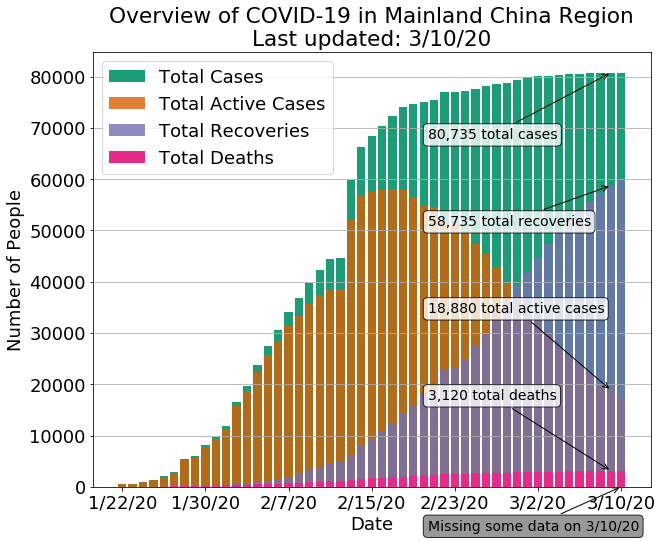

In [19]:
plot_regions(["Mainland China"])

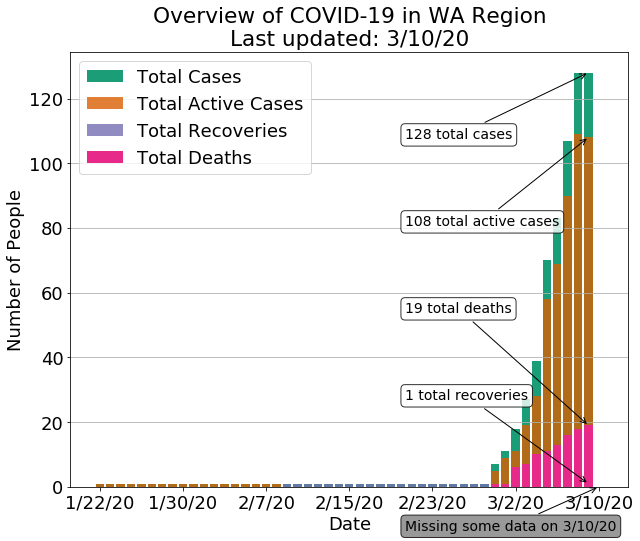

In [20]:
plot_states(["WA"])

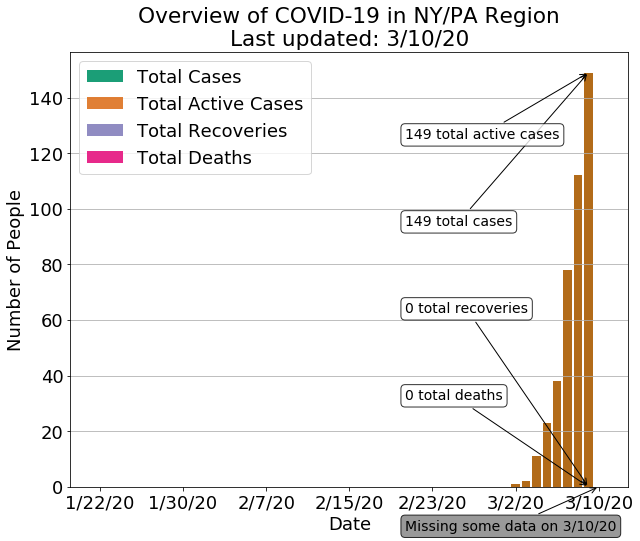

In [21]:
plot_states(["NY", "PA"])

# Now, plot counties or groups of counties

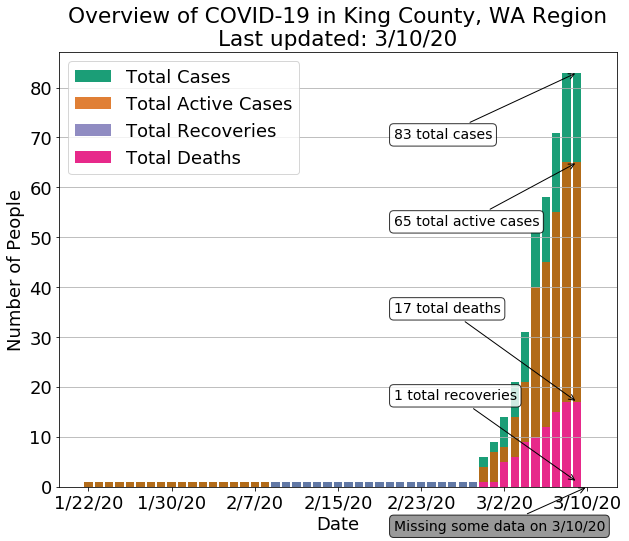

In [22]:
plot_counties(["King County, WA"])

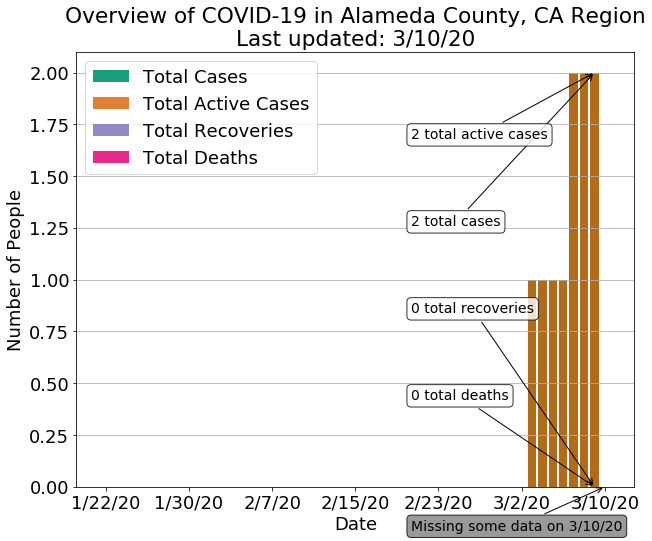

In [23]:
plot_counties(["Alameda County, CA"])

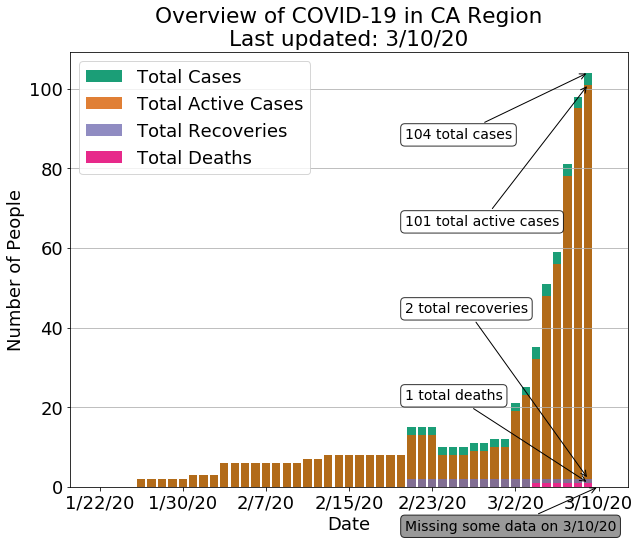

In [24]:
plot_states(["CA"])

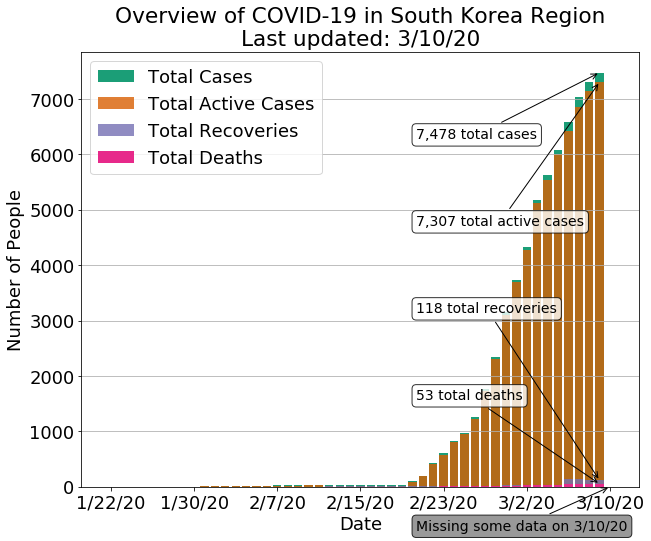

In [25]:
plot_regions(["South Korea"])

In [26]:
## You could make a plot of all 108 regions in the current data with the below as a stub.
# fig, axes = plt.subplots(10, 11, figsize=(30,30))
# axes = axes.ravel()
# for idx, region in enumerate(regions):
#     ax = axes[idx]
#     plot_regions([region], ax=ax, fig=fig)